In [1]:
!pip install lets_plot -q
!pip install tflite-runtime -q 
!pip install https://github.com/Martlgap/face-alignment-mtcnn/releases/latest/download/face_alignment_mtcnn-0.3-py3-none-any.whl -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.12.2 requires cupy-cuda115, which is not installed.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
librosa 0.10.0 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
distributed 2021.11.2 requires dask==2021.11.2, but you have dask 2022.2.0 which is incompatible.
datasets 2.1.0 requires tqdm>=4.62.1, but you have tqdm 4.61.2 which is incompatible.
dask-cudf 21.12.2 requires dask<=2021.11.2,>=2021.11.1, but you have dask 2022.2.0 which is incompatib

In [2]:
from torchvision import transforms
from torch.autograd import Variable
from timeit import default_timer as timer
from lets_plot import *

import facealignment
import os
import cv2
import torch.utils.data as data
import pandas as pd
import random
import numpy as np
import torch.nn.functional as F
import torch
import torchvision.models as models
import pickle
import torch.nn as nn
import math
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print(f'Using GPU : {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    gpu = 0 
    print(f'Using CPU')

Using GPU : Tesla P100-PCIE-16GB


In [4]:
LetsPlot.setup_html()

In [5]:
workers = 2 # number of workers
batch_size = 32 # batch size
w = 7 # width of attention map
h = 7 # height of attention map
gpu = 1 # gpu devices
lam = 5 # kl_lambda param
epochs = 100 # epochs

In [6]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [7]:
def add_g(image_array, mean=0.0, var=30):
    std = var ** 0.5
    image_add = image_array + np.random.normal(mean, std, image_array.shape)
    image_add = np.clip(image_add, 0, 255).astype(np.uint8)
    return image_add

def flip_image(image_array):
    return cv2.flip(image_array, 1)
    
def generate_flip_grid(w, h, device):
    # used to flip attention maps
    x_ = torch.arange(w).view(1, -1).expand(h, -1)
    y_ = torch.arange(h).view(-1, 1).expand(-1, w)
    grid = torch.stack([x_, y_], dim=0).float().to(device)
    grid = grid.unsqueeze(0).expand(1, -1, -1, -1)
    grid[:, 0, :, :] = 2 * grid[:, 0, :, :] / (w - 1) - 1
    grid[:, 1, :, :] = 2 * grid[:, 1, :, :] / (h - 1) - 1
    grid[:, 0, :, :] = -grid[:, 0, :, :]
    return grid

In [37]:
class RafDataset(data.Dataset):
    def __init__(self, df, directory, phase, basic_aug=True, transform=None, 
                 align=True, need_align=False):
        self.phase = phase
        self.basic_aug = basic_aug
        self.transform = transform
        self.directory = directory
        self.aug_func = [flip_image, add_g]
        self.file_paths = df.image.values
        self.labels = df.emotion.values - 1
        self.align = align
        self.need_align = need_align
        self.tools = facealignment.FaceAlignmentTools()

        del df
        

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        if self.align:
            image_name = self.file_paths[idx][:-4] + "_aligned.jpg"
        else:
            image_name = self.file_paths[idx]
        full_path = os.path.join(self.directory, image_name)
        image = cv2.imread(full_path)

        image = image[:, :, ::-1]
        
        if self.need_align:
            image_align = self.tools.align(image)
            if image_align is not None:
                image = image_align
                
        image1 = image
        image1 = self.aug_func[0](image)
        image1 = self.transform(image1)

        if self.phase == 'train':
            if self.basic_aug and random.uniform(0, 1) > 0.5:
                image = self.aug_func[1](image)

        if self.transform is not None:
            image = self.transform(image)
        
        image1 = transforms.RandomHorizontalFlip(p=1)(image)

        return image, label, idx, image1

In [38]:
def ACLoss(att_map1, att_map2, grid_l, output):
    flip_grid_large = grid_l.expand(output.size(0), -1, -1, -1)
    flip_grid_large = Variable(flip_grid_large, requires_grad = False)
    flip_grid_large = flip_grid_large.permute(0, 2, 3, 1)
    att_map2_flip = F.grid_sample(att_map2, flip_grid_large, mode = 'bilinear', padding_mode = 'border', align_corners=True)
    flip_loss_l = F.mse_loss(att_map1, att_map2_flip)
    return flip_loss_l

In [39]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [40]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [41]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=8631, include_top=True):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.include_top = include_top
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        
        if not self.include_top:
            return x
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [42]:
class Model(nn.Module):
    
    def __init__(self, resnet50_path, pretrained=True, num_classes=7):
        super(Model, self).__init__()
        resnet50 = ResNet(Bottleneck, [3, 4, 6, 3])
        with open(resnet50_path, 'rb') as f:
            obj = f.read()
        weights = {key: torch.from_numpy(arr) for key, arr in pickle.loads(obj, encoding='latin1').items()}
        resnet50.load_state_dict(weights)
        
        self.features = nn.Sequential(*list(resnet50.children())[:-2])  
        self.features2 = nn.Sequential(*list(resnet50.children())[-2:-1])  
        self.fc = nn.Linear(2048, 7)  
        
        
    def forward(self, x):        
        x = self.features(x)
        #### 1, 2048, 7, 7
        feature = self.features2(x)
        #### 1, 2048, 1, 1
        
        feature = feature.view(feature.size(0), -1)
        output = self.fc(feature)
        
        params = list(self.parameters())
        fc_weights = params[-2].data
        fc_weights = fc_weights.view(1, 7, 2048, 1, 1)
        fc_weights = Variable(fc_weights, requires_grad = False)

        # attention
        feat = x.unsqueeze(1) # N * 1 * C * H * W
        hm = feat * fc_weights
        hm = hm.sum(2) # N * self.num_labels * H * W

        return output, hm

In [43]:
def test(model, test_loader, device, show=False, k=6):
    k = k
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        iter_cnt = 0
        correct_sum = 0
        data_num = 0


        for batch_i, (imgs1, labels, indexes, imgs2) in enumerate(test_loader):
            imgs1 = imgs1.to(device)
            labels = labels.to(device)


            outputs, _ = model(imgs1)


            loss = nn.CrossEntropyLoss()(outputs, labels)

            iter_cnt += 1
            _, predicts = torch.max(outputs, 1)

            correct_num = torch.eq(predicts, labels).sum()
            correct_sum += correct_num

            running_loss += loss
            
            if show:
                if batch_i < k:
                    print(f'labels : {label_to_emotion(labels[0].item())}')
                    print(f'predicts: {label_to_emotion(predicts[0].item())}')
                    plt.imshow(imgs1.detach().cpu()[0].numpy().reshape(224, 224, 3))
                    plt.show()

            data_num += outputs.size(0)

        running_loss = running_loss / iter_cnt
        test_acc = correct_sum.float() / float(data_num)
    return test_acc, running_loss

In [44]:
train_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(scale=(0.02, 0.25)) ])
    
eval_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

In [45]:
def label_to_emotion(label):
    return {
        0 : 'Surprise',
        1 : 'Fear',
        2 : 'Disgust',
        3 : 'Happiness',
        4 : 'Sadness',
        5 : 'Anger',
        6 : 'Neutral'
    }[label]

In [46]:
def get_emotion_by_id(emotion_id):
    id_to_emotion = {
            1 : 'Surprise',
            2 : 'Fear',
            3 : 'Disgust',
            4 : 'Happiness',
            5 : 'Sadness',
            6 : 'Anger',
            7 : 'Neutral'
    }
    return id_to_emotion[emotion_id]

In [47]:
def get_distribution(data):
    freq = []
    for i in range(len(np.unique(data.emotion.values))):
        freq.append(len(data[data.emotion == np.unique(data.emotion.values)[i]]))
        
        
    stat_info_pd = pd.DataFrame({
        'Emotion' : map(get_emotion_by_id, np.unique(data.emotion.values)),
        'Frequency' : freq
    })
    assert(sum(stat_info_pd.Frequency.values)) == len(data)
    return stat_info_pd

In [48]:
path_to_labels = '/kaggle/input/eacdata/raf-basic/EmoLabel/list_patition_label.txt'
path_to_images = '/kaggle/input/raf-db-aligned-data/aligned'


In [49]:
self_annotated_train = pd.read_csv('/kaggle/input/self-annotated-train/train_self_labeled_dualstylegan.csv')
self_annotated_train = self_annotated_train[['image ', 'emotion']]
self_annotated_train = self_annotated_train.rename(columns={'image ': 'image'})

self_annotated_train.head() 

,image,emotion
0,train_00001.jpg,7
1,train_00002.jpg,7
2,train_00003.jpg,7
3,train_00004.jpg,7
4,train_00005.jpg,5


In [50]:
self_annotated_train_dataset = RafDataset(self_annotated_train, '/kaggle/input/generated-dataset/gen_data', phase='train',
                                          transform=train_transforms, align=False)

print(len(self_annotated_train_dataset))

300


In [51]:
raf_db_data = pd.read_csv(path_to_labels, sep=" ", header=None)
raf_db_data.rename(columns={0 : 'image', 1 : 'emotion'}, inplace=True)
print(raf_db_data.shape)
raf_db_data.head()

(15339, 2)


,image,emotion
0,train_00001.jpg,5
1,train_00002.jpg,5
2,train_00003.jpg,4
3,train_00004.jpg,4
4,train_00005.jpg,5


In [52]:
info = get_distribution(raf_db_data)
print('All Data')
ggplot(info, aes(x=info.Emotion,  weight=info.Frequency, 
           fill=info.Emotion)) + \
geom_bar() + labs(x='Emotion', y='Times Occured')

All Data


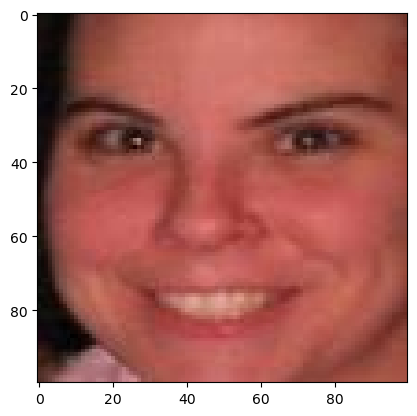

In [53]:
sample = cv2.imread('/kaggle/input/raf-db-aligned-data/aligned/train_01989_aligned.jpg')
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
plt.imshow(sample)
plt.show()

In [54]:
train_data = raf_db_data[raf_db_data.image.str.contains('train')]
test_data = raf_db_data[raf_db_data.image.str.contains('test')]

del raf_db_data

In [55]:
info = get_distribution(train_data)
print('RAF_DB train Data')
ggplot(info, aes(x=info.Emotion,  weight=info.Frequency, 
           fill=info.Emotion)) + \
geom_bar() + labs(x='Emotion', y='Times Occured')

RAF_DB train Data


In [56]:
def get_densities(data, need_images):
    densities = []
    for emotion in np.unique(data.emotion.values):
        amount = len(data[data.emotion == emotion])
        density = amount / len(data)
        densities.append((get_emotion_by_id(emotion), density))
        
    sum_density = 0
    
    for emotion, density in densities:
        print(f'Density for emotion {emotion} = {density:.3f}, for {need_images} -> {int(need_images * density)}')
        sum_density += density
        
    assert  1.0 - 1e-9 <= sum_density <= 1.0 + 1e-9
    
get_densities(test_data, 300)

Density for emotion Surprise = 0.107, for 300 -> 32
Density for emotion Fear = 0.024, for 300 -> 7
Density for emotion Disgust = 0.052, for 300 -> 15
Density for emotion Happiness = 0.386, for 300 -> 115
Density for emotion Sadness = 0.156, for 300 -> 46
Density for emotion Anger = 0.053, for 300 -> 15
Density for emotion Neutral = 0.222, for 300 -> 66


In [57]:
info = get_distribution(test_data)
print('RAF-DB test Data')
ggplot(info, aes(x=info.Emotion,  weight=info.Frequency, 
           fill=info.Emotion)) + \
geom_bar() + labs(x='Emotion', y='Times Occured')

RAF-DB test Data


Train : 12271
Test : 3068
Sample : (tensor([[[ 1.5125,  1.4612,  1.3242,  ...,  0.5878,  0.6049,  0.6221],
         [ 1.5125,  1.4783,  1.3927,  ...,  0.5878,  0.6049,  0.6221],
         [ 1.5297,  1.5468,  1.5810,  ...,  0.6049,  0.6049,  0.6049],
         ...,
         [-0.1486, -0.1486, -0.1486,  ..., -0.6794, -0.6794, -0.6965],
         [-0.1314, -0.1486, -0.1657,  ..., -0.6623, -0.6965, -0.7137],
         [-0.1314, -0.1486, -0.1828,  ..., -0.6623, -0.7137, -0.7308]],

        [[-0.1625, -0.1975, -0.2850,  ...,  0.0651, -0.0049, -0.0399],
         [-0.0749, -0.1099, -0.1625,  ...,  0.0651, -0.0049, -0.0399],
         [ 0.1352,  0.1352,  0.1527,  ...,  0.0476, -0.0224, -0.0399],
         ...,
         [-0.9503, -0.9503, -0.8803,  ..., -1.3354, -1.2829, -1.2479],
         [-0.9328, -0.9328, -0.9328,  ..., -1.3880, -1.3004, -1.2654],
         [-0.9153, -0.9328, -0.9503,  ..., -1.4055, -1.3004, -1.2654]],

        [[-0.5321, -0.6193, -0.8633,  ..., -1.2641, -1.2467, -1.2467],
         

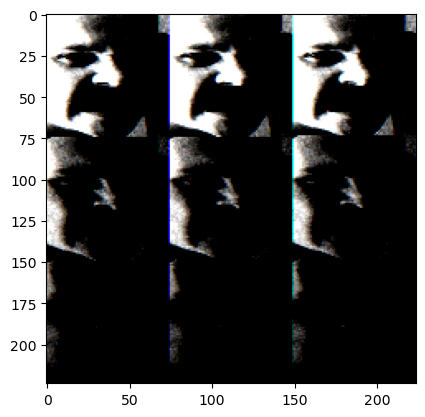

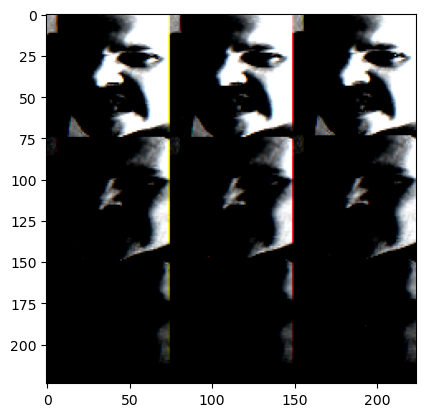

In [58]:
train_dataset = RafDataset(train_data, path_to_images, phase='train', transform=train_transforms)
test_dataset = RafDataset(test_data, path_to_images, phase='test', transform=eval_transforms)

print(f'Train : {len(train_dataset)}')
print(f'Test : {len(test_dataset)}')
print(f'Sample : {train_dataset[1000]}')
plt.imshow(train_dataset[1000][0].numpy().reshape(224, 224, 3))
plt.show()
plt.imshow(train_dataset[1000][3].numpy().reshape(224,224,3))

In [59]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=workers,
                                           pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=workers,
                                          pin_memory=True)

print(f'Num of batches train : {len(train_loader)}')
print(f'Num of batches test : {len(test_loader)}')

Num of batches train : 384
Num of batches test : 96


In [60]:
resnet_50_path = '/kaggle/input/eacdata/resnet50_ft_weight.pkl'

In [61]:
model = Model(resnet_50_path)
model.to(device)

Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 25

In [62]:
optimizer = torch.optim.Adam(model.parameters() , lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [63]:
test_mode = True

path_to_model = '/kaggle/input/eac-model-saved/eac_acc_0.904172.pth'

Model loaded...
labels : Sadness
predicts: Sadness


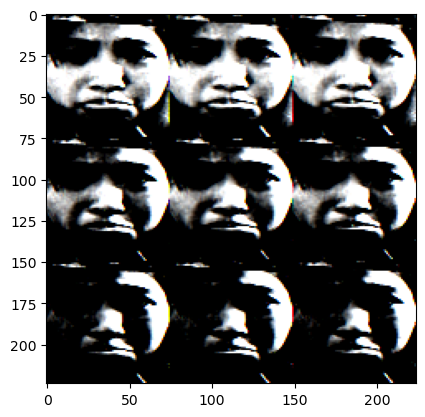

labels : Happiness
predicts: Happiness


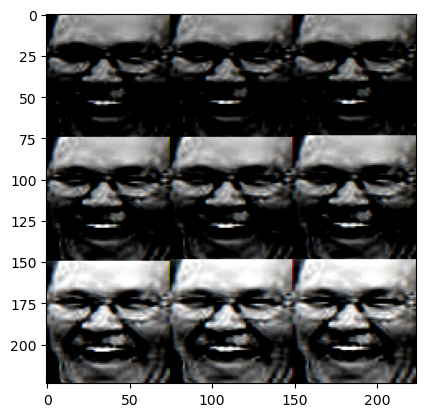

labels : Happiness
predicts: Happiness


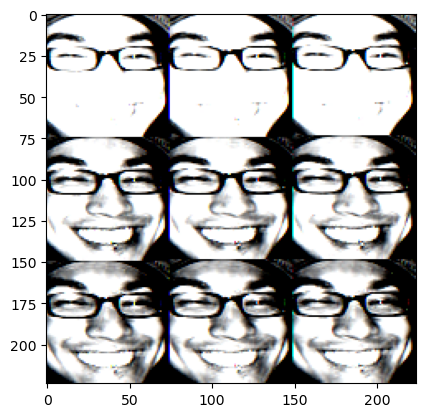

labels : Happiness
predicts: Happiness


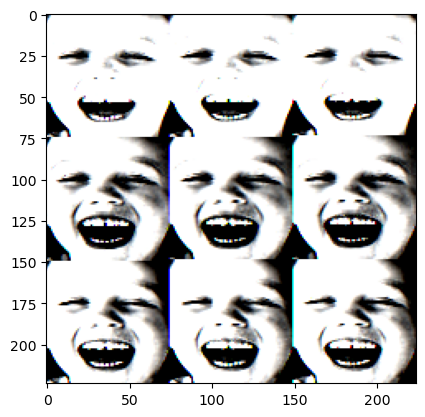

labels : Happiness
predicts: Happiness


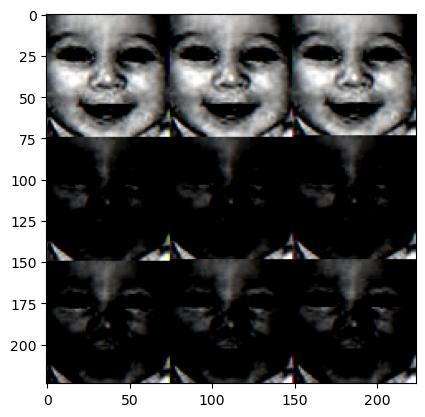

labels : Happiness
predicts: Happiness


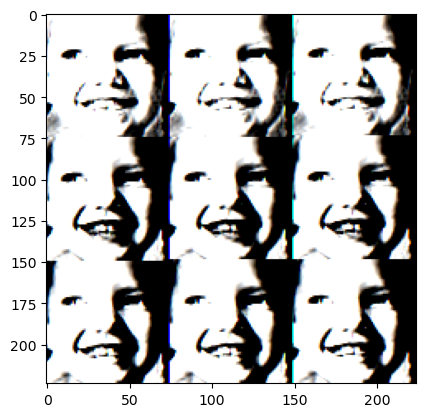

In [64]:
setup_seed(0)

if test_mode:
    model.load_state_dict(torch.load(path_to_model)['model_state_dict'])
    print(f'Model loaded...')
    test_acc, test_loss = test(model, test_loader, device, show=True)    
else:
    trainer(epochs)

In [65]:
print(f'#-----Testing on Real Faces RAF_DB------#')
print(f'nTest Accuracy: {test_acc}, Test Loss : {test_loss}')

#-----Testing on Real Faces RAF_DB------#
nTest Accuracy: 0.9041720628738403, Test Loss : 0.34259161353111267


In [67]:
path_to_avatars_orig = '/kaggle/input/generated-dataset/gen_data'

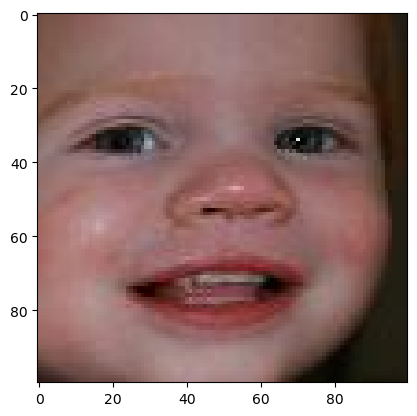

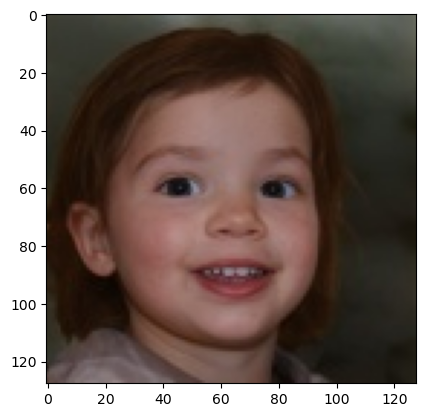

In [70]:
avatar_example = cv2.imread('/kaggle/input/generated-dataset/gen_data/test_1025.jpg')
avatar_example = cv2.cvtColor(avatar_example, cv2.COLOR_BGR2RGB)
real_example = cv2.imread('/kaggle/input/raf-db-aligned-data/aligned/test_1025_aligned.jpg')
real_example = cv2.cvtColor(real_example, cv2.COLOR_BGR2RGB)
plt.imshow(real_example)
plt.show()
plt.imshow(avatar_example)
plt.show()

In [72]:
avatars_data_test = pd.read_csv('/kaggle/input/gen-data-labels/generated_test.csv')
avatars_data_train = pd.read_csv('/kaggle/input/gen-data-labels/generated_train.csv')
avatars_data_val = pd.read_csv('/kaggle/input/gen-data-labels/generated_val.csv')
avatars_data = pd.concat([avatars_data_test, avatars_data_train, avatars_data_val])

del avatars_data_test
del avatars_data_train
del avatars_data_val

In [73]:
info = get_distribution(avatars_data)
print('Avatars Data')
ggplot(info, aes(x=info.Emotion,  weight=info.Frequency, 
           fill=info.Emotion)) + \
geom_bar() + labs(x='Emotion', y='Times Occured')

Avatars Data


In [74]:
print(avatars_data.shape)
avatars_data.head()

(15339, 2)


,image,emotion
0,test_0001.jpg,5
1,test_0002.jpg,1
2,test_0003.jpg,4
3,test_0005.jpg,5
4,test_0006.jpg,5


In [75]:
avatars_train_data = avatars_data[avatars_data.image.str.contains('train')]
avatars_test_data = avatars_data[avatars_data.image.str.contains('test')]

# del avatars_data

print(f'Train avatars: {len(avatars_train_data)}')
print(f'Test avatars: {len(avatars_test_data)}')

Train avatars: 12271
Test avatars: 3068


In [76]:
info = get_distribution(avatars_test_data)
print('Avatars test Data')
ggplot(info, aes(x=info.Emotion,  weight=info.Frequency, 
           fill=info.Emotion)) + \
geom_bar() + labs(x='Emotion', y='Times Occured')

Avatars test Data


In [77]:
test_avatars_annotated = pd.read_csv('/kaggle/input/self-annotated-test/test_annotated.csv')

test_avatars_annotated

,image,emotion
0,test_0001.jpg,5
1,test_0002.jpg,7
2,test_0003.jpg,4
3,test_0005.jpg,7
4,test_0006.jpg,7
...,...,...
95,test_0109.jpg,4
96,test_0110.jpg,7
97,test_0111.jpg,4
98,test_0112.jpg,4


In [85]:
test_dataset_self_annotated = RafDataset(test_avatars_annotated, '/kaggle/input/generated-dataset/gen_data',
                                  phase='test', transform=eval_transforms, align=False, need_align=True)

print(len(test_dataset_self_annotated))

100


In [86]:
test_loader_self_annotated = torch.utils.data.DataLoader(test_dataset_self_annotated, batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=workers,
                                          pin_memory=True)

print(len(test_loader_self))

4


#------Testing model on self annotated avatars------#


INFO: INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
Created TensorFlow Lite XNNPACK delegate for CPU.


labels : Sadness
predicts: Sadness


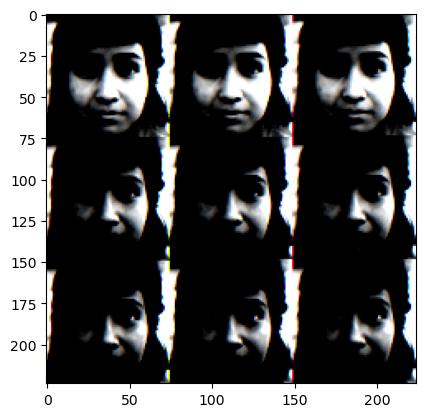

labels : Neutral
predicts: Neutral


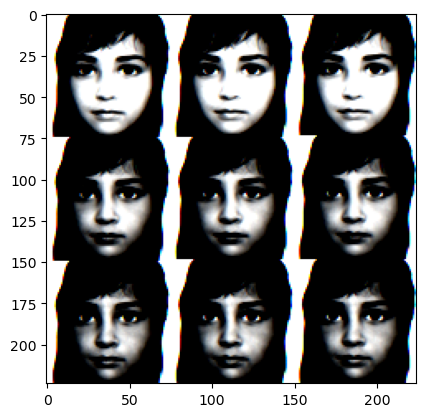

labels : Happiness
predicts: Happiness


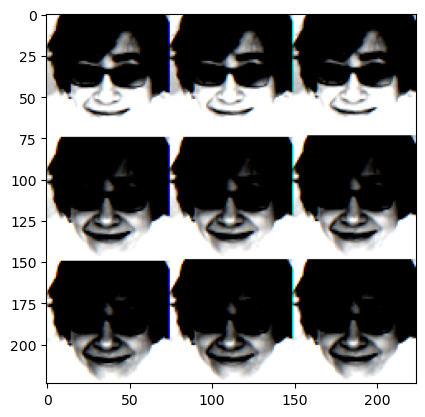

labels : Neutral
predicts: Happiness


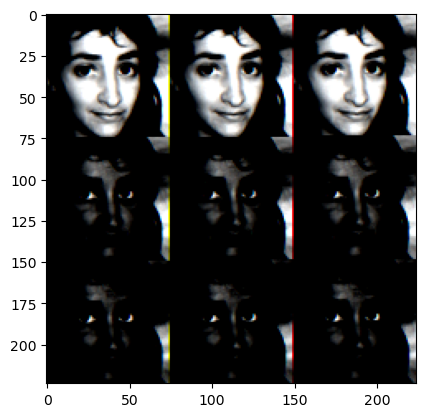

Test Accuracy : 0.6499999761581421
Test Loss : 0.9925664663314819


In [87]:
test_mode = True
if test_mode:
    setup_seed(0)
    print(f'#------Testing model on self annotated avatars------#')
    test_acc, test_loss = test(model, test_loader_self_annotated, device, show=True)

print(f'Test Accuracy : {test_acc}')
print(f'Test Loss : {test_loss}')